> **Topic:** Introduction to Neural Network using PyTorch
>
> **Module:** Preparing the Training Script
>
> **Presentor:** Industry Sandbox and AI Computing (ISAIC)
>
> **Date:** 

## Neural Network Model Training

**Add point: specify that epochs go over the entire dataset every time**

After building a model, the next step is to train the model on our data. The training step here referes to the optimzation of model parameters in iterative process using stochastic gradient descent. Before we can start the training, there few prior steps to set up the stage:

- Set the number of epochs to train for. Number of epochs referes to how long the iterative process of optimization shoud run for.

- Set the attributes to initialize our model. For example, our model takes attributes such as input dimension, hidden layer dimension, etc.

- After initializing the model, we can set the type of device we want our model to train on. By default, the model runs on CPU. However, if GPU is available, model should be run on GPU as it perfroms faster.

- We then need to set the optimizer for our model. Optimizer is the tool that perfroms the model parameter optimization for us.

Let us first prepare this setup.

- **Load the dataset**

In [2]:
#import pytorch modules
import torch
from torch.utils.data import Dataset
from torchvision import datasets
#from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader

#import numpy module
import numpy as np

#import plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', dpi=350)
%matplotlib inline


pre_processing = transforms.Compose(
                [transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])])

train_data = datasets.FashionMNIST(
                    root='FMNIST',
                    train=True,
                    download=False,
                    transform=pre_processing)
test_data  = datasets.FashionMNIST(
                    root='FMNIST',
                    train=False,
                    download=False,
                    transform=pre_processing)


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=True)


- **Build the model**

In [3]:
#load necessary modules
import torch.nn as nn
import torch.nn.functional as F

#define the model class
class ImageClass(nn.Module):
    '''
    Main class that defines the Neural Net model (inheritence from nn.Module)
    Input - input_dim (int): Input dimension for each sample data
            hidden_dim (list): Each element in the list denotes the dimension
                            of each hidden layer
            output_dim (int): Output dimension (in our example case, 10 for 
                            total 10 classes of image)
            dropout_rate (float) [optional]: Rate at which Dropout regularization is applied
            use_batchnorm (bool) [optional]: Whether to use batch normalization after each
                                            hidden layer affine transformation
            **kwargs: Additional keyword arguments
    '''
    
    def __init__(self, input_dim, hidden_dim=[64,64,64], output_dim=10,
                dropout_rate = 0.0, use_batchnorm=False, **kwargs):
        super(ImageClass, self).__init__(**kwargs)
        
        #define an empty ModuleList container
        self.linear_model = nn.ModuleList()
        
        #first flatten our 2D image data into one dimension
        self.linear_model.append(nn.Flatten())
        
        #then we build our hidden layers iteratively (based on the # hidden layers)
        for i, (in_channel, out_channel) in enumerate(
                                zip([input_dim]+hidden_dim[:-1], hidden_dim)):
            #we first build the affine transformation
            self.linear_model.append(nn.Linear(in_channel, out_channel, bias=True))
            if use_batchnorm:
                #then apply batch normalization, if turned on for the model
                self.linear_model.append(nn.BatchNorm1d(out_channel))
            #we then apply the activation function
            self.linear_model.append(nn.ReLU())
            if dropout_rate:
                #we also add dropout is this regularization is turned on
                self.linear_model.append(nn.Dropout(dropout_rate))
        #add the last layer, i.e. the model output
        self.linear_model.append(nn.Linear(hidden_dim[-1], output_dim, bias=True))
        self.linear_model.append(nn.LogSoftmax(dim=1))
        
    def forward(self,x):
        for layer in self.linear_model:
            x = layer(x)
        return x

- **Set up the pre-training steps**

Variables such as number of epochs, choice of optimizer, number of hidden layers and dimensions of each hidden layer, learning rate for the optimizer are called hyperparameters of the model. These parameters are set by user choice and can be varied to find the best model in a process called *Hyperparameter Tuning*.

In [4]:
#necessary python modules (provides the optimizer library)
import torch.optim as optim


######  Hyperparameter settings  #######

#Number of epochs to train for
N_EPOCHS = 20

#define the loss function, i.e. negative log-likelihood function (acting on log-Softmax model output)
loss_function = F.nll_loss

#Initialize the model with set architecture
input_dim = 28*28 #pixel size for our dataset
hidden_dim = [64,64,64] #List of dimensions in each hidden layer
output_dim = 10 #dimension of the output layer

#Regularization parameter
dropout_rate=0.3
use_batchnorm=True

#initialize the model
model = ImageClass(input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
                  dropout_rate=dropout_rate, use_batchnorm=use_batchnorm)

#****IMPORTANT: move the model to GPU (if allowed), before constructing optimizer
#set the proper device (use GPU to train on if available)
if torch.cuda.is_available():
    model = model.cuda()


#set the learning rate to use for the optimizer
learning_rate = 0.001
#initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

#momentum = 0.9
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)


## Monitoring the Training Progress

Observation of the training process is an important step as it can indicate us if the model is training properly. After each epoch of iterative optimization, we can apply the model on our test sample and see how accurately the model is classifying the objects in the dataset.

To implement this, let's define a function `evaluate` that evaluates the accuracy of given dataset.

In [5]:
from sklearn.metrics import accuracy_score
def evaluate(model, dataloader, loss_function):
    model.eval()
    y_true = np.zeros(len(dataloader.dataset))
    y_pred = np.zeros(len(dataloader.dataset))
    
    total_loss=0
    
    for batch_idx, (X,y) in enumerate(dataloader):
        print(f'\rEvaluating {batch_idx + 1} / {len(dataloader)}', end='\r')
        y_i = model(X)
        loss = loss_function(y_i, y)
        idx_start = batch_idx*dataloader.batch_size
        idx_stop  = (batch_idx+1)*dataloader.batch_size
        y_true[idx_start:idx_stop] = y.data.numpy()
        y_pred[idx_start:idx_stop] = y_i.data.max(dim=1)[1].numpy()
        total_loss+= loss.item()
    acc = accuracy_score(y_true, y_pred)
    loss = total_loss/len(dataloader)
    print (f'Running Metrics: Accuracy Score: {acc}, Loss: {loss}')
    return (y_true, y_pred, acc, loss)

In the stochastic gradient descent training process, for each epoch and batch iteration of data, we first compute the loss of the model for the given data, called **forward propagation** and then calculate the gradients of parameter in a process called **backpropagation**. **Gradient descent** step then updates the parameter values based on the first two computation mentioned above.

Even for a simplest neural network, the number of parameters in the model is too large and nested to calculate the gradients of each parameter by hand. Pytorch provides a tool called `torch.autograd` which is the automatic differentiation engine that powers as the backbone of neural network training process.

Automatic differentiation algorithm generates a computation graph of the derivatives for each parameter in the model based on *chain rule of differentiation*. For more details on `torch.autograd` please see [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

Let's write our training script now.

In [6]:
for epoch in range(N_EPOCHS):
    #print the running epch number
    print (f'\nEpoch {epoch+1}/{N_EPOCHS}')
    #set the model to training mode
    model.train()
    #variable to calculate running loss (for each epoch)
    epoch_loss = 0
    epoch_accu = 0
    for batch_idx, data in enumerate(train_loader):
        X, y = data
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_accu += accuracy_score(y.data.numpy(),y_pred.data.max(dim=1)[1].numpy())
    #print the model performance using test dataset
    print ('Validation###')
    _, _, test_accu, test_loss = evaluate(model, test_loader, loss_function)
    


Epoch 1/20
Validation###
Running Metrics: Accuracy Score: 0.8381, Loss: 0.44751478155580954

Epoch 2/20
Validation###
Running Metrics: Accuracy Score: 0.8514, Loss: 0.4100803568149908

Epoch 3/20
Validation###
Running Metrics: Accuracy Score: 0.8533, Loss: 0.4044238894987411

Epoch 4/20
Validation###
Running Metrics: Accuracy Score: 0.8604, Loss: 0.3865040617343336

Epoch 5/20
Validation###
Running Metrics: Accuracy Score: 0.8602, Loss: 0.3869975897165152

Epoch 6/20
Validation###
Running Metrics: Accuracy Score: 0.8664, Loss: 0.3701673105549508

Epoch 7/20
Validation###
Running Metrics: Accuracy Score: 0.8633, Loss: 0.37451142924852643

Epoch 8/20
Validation###
Running Metrics: Accuracy Score: 0.8639, Loss: 0.38062681371982865

Epoch 9/20
Validation###
Running Metrics: Accuracy Score: 0.8626, Loss: 0.36962627300534384

Epoch 10/20
Validation###
Running Metrics: Accuracy Score: 0.8684, Loss: 0.35694702707540493

Epoch 11/20
Validation###
Running Metrics: Accuracy Score: 0.8671, Loss: 

## Model's Performance after Training

In order to evaluate the final performance of the model, we can check the model's accuracy for each class in a so-called **confusion matrix**. Confusion matrix shows the correlation of true class and predicted class of each sample in the dataset in a matrix form and can give us detailed insights about the trained model's performance.

In [12]:
from sklearn.metrics import confusion_matrix

#get the true and predicted labels of the test dataset
y_true, y_pred, _, _ = evaluate(model, test_loader, loss_function)

#compute the confusion matrix using sklearn
cmatrix = confusion_matrix(y_true, y_pred, normalize='true')


Running Metrics: Accuracy Score: 0.8791, Loss: 0.3390127986717148


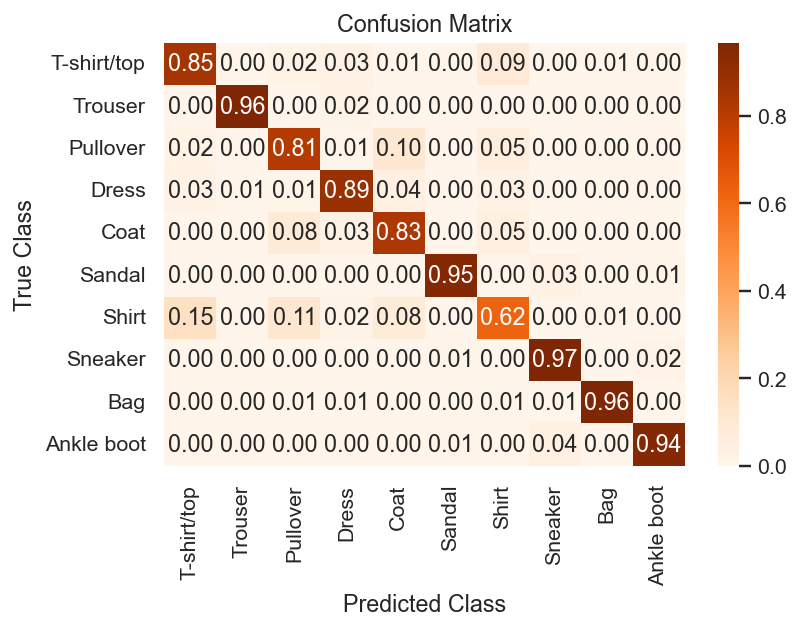

In [26]:
#plot the confusion matrix using seaborn
import pandas as pd
import seaborn as sn 
sn.set(rc={"figure.dpi":140})
df_cm = pd.DataFrame(cmatrix, index=train_data.classes, columns=train_data.classes)
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, fmt='.02f')
ax.set_title('Confusion Matrix');
ax.set_xlabel("Predicted Class");
ax.set_ylabel("True Class");